## Postgres Representation

Importing python libraries

In [1]:
import sqlalchemy
import psycopg2 as ps
import pandas.io.sql as sqlio
import matplotlib.pyplot as plt

To create a connection between jupyter notebook and postgres

In [4]:
conn2 = ps.connect(dbname = "postgres", user = "ag_class", password = "WUcgdfQ1", host = "awesome-hw.sdsc.edu", port = "5432")

sbir_award_data

Statistical Analysis

Selecting Average of award amount, median and mode, min and max of award amount through the years

In [ ]:
sql = """ select distinct award_year, round(avg(award_amount) over (partition by award_year),2) as mean, percentile_cont(0.5) within group ( order by award_amount ) as median, mode() within group ( order by award_amount ) as mode, min(award_amount) over (partition by award_year) as min, max(award_amount) over (partition by award_year) as max from "Result_12" group by award_amount, award_year order by award_year;
"""

In [ ]:
df = sqlio.read_sql_query(sql,conn2)

In [ ]:
chart = df.plot(x="award_year", y=["mean", "median","mode","min","max"], kind="bar", figsize = (16,12))


In [ ]:
df

In [ ]:
chart = df.plot(x="award_year", y=["mean", "median","mode","min","max"], kind="line", figsize = (16,12))


Finding each of the company's year wise awards and which one occurs the most

In [ ]:
sql = """select sum(award_amount) over (partition by company order by award_amount) as total , company , award_year from "Result_12" group by award_year, company, award_amount order by company, award_year;

select distinct c.company, c.occurence, c."Awarding_branches" , R.recordid from company_occurence c, "Result_12" R where c.company = R.company
 """

In [ ]:
df = sqlio.read_sql_query(sql,conn2)

In [ ]:
df.plot(x="highestawardcompany", y=["award_amount","award_year"], kind="line", figsize = (18,10))


Finding companies getting the highest award

In [ ]:
sql = """select distinct first_value(company) over (partition by award_year order by award_amount) as highestAwardCompany, award_year , award_amount from "Result_12" group by award_year, award_amount, company order by award_year;"""

In [ ]:
df = sqlio.read_sql_query(sql,conn2)

In [ ]:
df.plot(x="highestawardcompany", y=["award_amount","award_year"], kind="bar", figsize = (18,10))


Finding the companies that are under-funded

In [ ]:
sql = """select company, sum from (select company, sum(award_amount) as sum from "Result_12"  group by cube ((company,award_amount)) having award_amount < 500 order by company, award_amount) a;
"""

In [ ]:
df = sqlio.read_sql_query(sql,conn2)

In [ ]:
df.plot(x="company", y="sum", kind="bar", figsize = (18,10))


patentdb

Finding the number of patents under each technology 

In [ ]:
sql = """select  (string_to_array((string_to_array(translate(classname, '[{][}]', ''), ';'))[1], ','))[1] as techword, patentid, translate(assignee_name_current,'{}','') as currentCompany from "patentdb (1)"
"""
df = sqlio.read_sql_query(sql,conn2)
df = df[df["techword"].notna()]
d = df.groupby('techword')['patentid']
d = df.groupby('techword')['patentid'].nunique()
d= d.to_frame()
r = d[d.patentid != 113]
dataframe = r
techword = ['CHEMISTRY', 'ELECTRICITY', 'FIXED CONSTRUCTIONS', 'HUMAN NECESSITIES', 'MECHANICAL ENGINEERING', 'PERFORMING OPERATIONS','PHYSICS','TEXTILES']
dataframe['techword'] = techword
dfN = dataframe[['patentid','techword']]
d.plot(x="techword", y="patentid", kind="bar", figsize = (20,10))

In [ ]:
dfN.plot(x="techword", y="patentid", kind="bar", figsize = (20,10))


Finding which companies use which technology

In [ ]:
sql ="""with a as (
select  (string_to_array((string_to_array(translate(classname, '[{][}]', ''), ';'))[1], ','))[1] as techword, patentid, translate(assignee_name_current,'{}','') as currentCompany from "patentdb (1)"

)
select distinct(currentCompany) as comp, techword from a where techword is not null and currentCompany is not null group by techword,currentCompany ;
"""

In [ ]:
df = sqlio.read_sql_query(sql,conn2)

In [ ]:
df=df.groupby(['comp','techword']).size()
df=df.unstack()
df.plot(kind='line', figsize = (20,10))

In [ ]:
df=df.groupby(['techword','comp']).size()
df=df.unstack()
df.plot(kind='bar', figsize = (20,10))


<AxesSubplot:xlabel='award_year'>

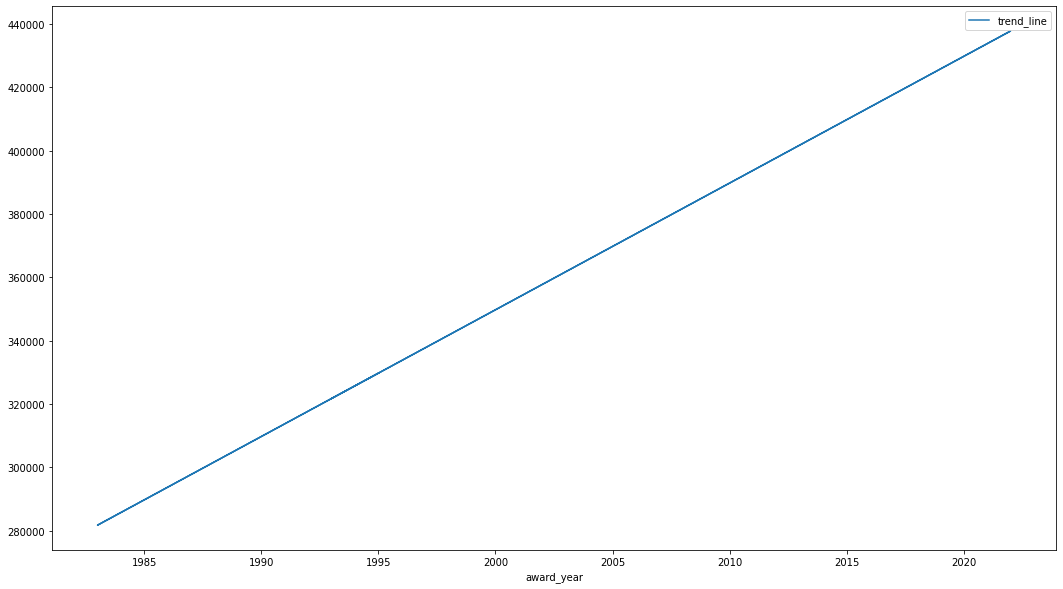

In [5]:
sql = """with a as (
select sum(award_amount) as sum, award_year, company
           from "NewResult"
           GROUP BY company, award_year),

    trend_line as(
        select slope,
               y_max - x_max * slope as intercept
        from(
            select
                coalesce((nullif(sum((award_year-x_bar)*(sum-y_bar)),0)/nullif(sum((award_year-x_bar)*(award_year-x_bar)),0)),0) as slope,
                max(x_bar) as x_max,
                max(y_bar) as y_max
            from(
                select award_year, avg(award_year) over() as x_bar,
                       sum, avg(sum) over() as y_bar
                from a
                )data1
            )data2
    )
select a.*,
       (a.award_year * (select slope from trend_line)+(select intercept from trend_line)) as trend_line
from a;"""
df = sqlio.read_sql_query(sql,conn2)
df.plot(x="award_year", y="trend_line", figsize = (18,10))


<AxesSubplot:xlabel='award_year'>

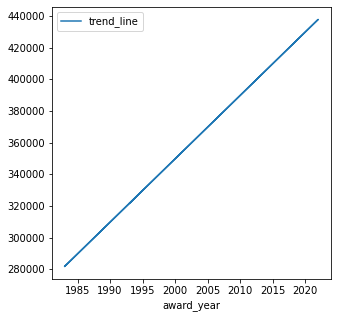

In [7]:
df.plot(x="award_year", y="trend_line", figsize = (5,5))


In [ ]:
df = sqlio.read_sql_query(sql,conn2)

In [ ]:
df.head(5)

In [ ]:
df.plot(x="award_year", y="trend_line", kind="line", figsize = (18,10))
